In [3]:
import torch
import torchvision

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from puzzles_v2 import * 

cfg = {
    "seed":20240116,
    "batch_size":128,
    "img_size":512,
    "train_size":0.999,
    "num_layers":3,
    "channels":5,
    
    "weight":0.9,
    "learning_rate":0.002,
    "weight_decay":0.0001,
    "num_epochs":1,
    "save_path":"/home/aiuser/taeuk",
    "path":"/home/aiuser/kyunghoney/data/Puzzle",
    "save_epoch":20
}

train_loader, valid_loader, test_loader = Loader(cfg)
img, imgs, plab, lab = next(iter(train_loader))

print(img.shape)
print(imgs.shape)
print(plab.shape)
print(lab.shape)


torch.Size([128, 3, 512, 512])
torch.Size([128, 16, 3, 128, 128])
torch.Size([128, 16, 32])
torch.Size([128, 4, 4])


In [ ]:
for idx in np.random.choice(len(test_loader.dataset), 10, replace=False):

    stride = 1
    img, imgs_print = test_loader.dataset[idx]

    fig, axe = plt.subplots(2, 5)
    pixels = list(range(1,stride*10+1,stride))
    for i in range(10):
        answer = solving_v1(pixels[i], imgs_print)
        image_pred, _ = shuffle_image(np.transpose(img.squeeze().numpy(),(1,2,0)), answer.reshape(-1).argsort())
        axe[i//5, i%5].imshow(image_pred)
        axe[i//5, i%5].axis("off")
    fig.show()

In [ ]:
#####################
# simple submission #
#####################

import torch
import torchvision

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from puzzles_v2 import * 

cfg = {
    "seed":20240116,
    "batch_size":128,
    "img_size":512,
    "train_size":0.999,
    "num_layers":3,
    "channels":5,
    
    "weight":0.9,
    "learning_rate":0.002,
    "weight_decay":0.0001,
    "num_epochs":1,
    "save_path":"/home/aiuser/taeuk",
    "path":"/home/aiuser/kyunghoney/data/Puzzle",
    "save_epoch":20
}

_, _, dataloader = Loader(cfg)

dataset = dataloader.dataset
submit = pd.read_csv('/home/aiuser/kyunghoney/data/Puzzle/sample_submission.csv')
for i in tqdm(range(len(dataset))):
    imgs = dataset[i][1]
    answer = solving_v1(1, imgs)
    answer += 1
    submit.iloc[i, 1:] = answer.reshape(-1)
    
submit.to_csv("./basic1.csv", index=False)

In [ ]:
############
# training #
############

# PID :[1] 1229768
# PID : 

import torch
import torchvision

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from puzzles_v2 import * 

# num_layers <= 5

cfg = {
    "batch_size":48,
    "img_size":512,
    "train_size":0.999,
    "num_layers":5,
    "channels":8,
    "pixel":2,
    
    "verbose":True,
    "label_prediction":True,
    "weight":0.9,
    "learning_rate":0.002,
    "weight_decay":0.0001,
    "num_epochs":5,
    "save_path":"/home/aiuser/taeuk/puzzle_saves",
    "path":"/home/aiuser/taeuk/puzzle_data",
    "save_epoch":20
}

#fix_random_seed(20240126)
train_loader, valid_loader, test_loader = Loader_v2(cfg)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(cfg).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["learning_rate"], weight_decay=cfg["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["num_epochs"]//5, eta_min=cfg["learning_rate"]/10)

best_model = train(cfg, device, model, optimizer, scheduler, train_loader, valid_loader)

In [1]:
#############
# inference #
#############

import torch
import torchvision

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from puzzles_v2 import * 

cfg = {
    "batch_size":48,
    "img_size":512,
    "train_size":0.999,
    "num_layers":5,
    "channels":8,
    "pixel":2,
    
    "verbose":False,
    "label_prediction":True,
    "weight":0.9,
    "learning_rate":0.002,
    "weight_decay":0.0001,
    "num_epochs":100,
    "save_path":"/home/aiuser/taeuk/puzzle_saves",
    "path":"/home/aiuser/kyunghoney/data/Puzzle",
    "save_epoch":20
}
fix_random_seed(20240126)
_, _, test_loader = Loader(cfg)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for ep in [90]:
    
    model_path = "/home/aiuser/taeuk/puzzle_saves/M5_B48_L5_C8_W0.9_lr0.002_Px2_Ep100.pt"
    csv_title = model_path.split("/")[-1][:-3] + "plus_v3"

    model = Model(cfg).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    preds = []
    images = []

    with torch.no_grad():
        for img, imgs in tqdm(test_loader):
            imgs = imgs.to(device)
            pred = model(imgs).softmax(dim=1)[:,1,:,:]
            preds.append(pred.detach().cpu())
            images.append(img)
            
    images = torch.cat(images, dim=0)
    hvs = torch.cat(preds, dim=0)
    hvs = hvs.numpy()
    
    submit = pd.read_csv('/home/aiuser/kyunghoney/data/Puzzle/sample_submission.csv')
    
    for i in tqdm(range(hvs.shape[0])):
        h = hvs[i][:, :16] * (np.ones((16,16)) - np.eye(16))
        v = hvs[i][:, 16:] * (np.ones((16,16)) - np.eye(16))
        answer = solving_v3(h, v, np.transpose(images[i], (1,2,0)))
        submit.iloc[i, 1:] = answer.argsort() + 1
    submit.to_csv("/home/aiuser/taeuk/puzzle_submit/%s.csv"%csv_title, index=False)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/59961 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

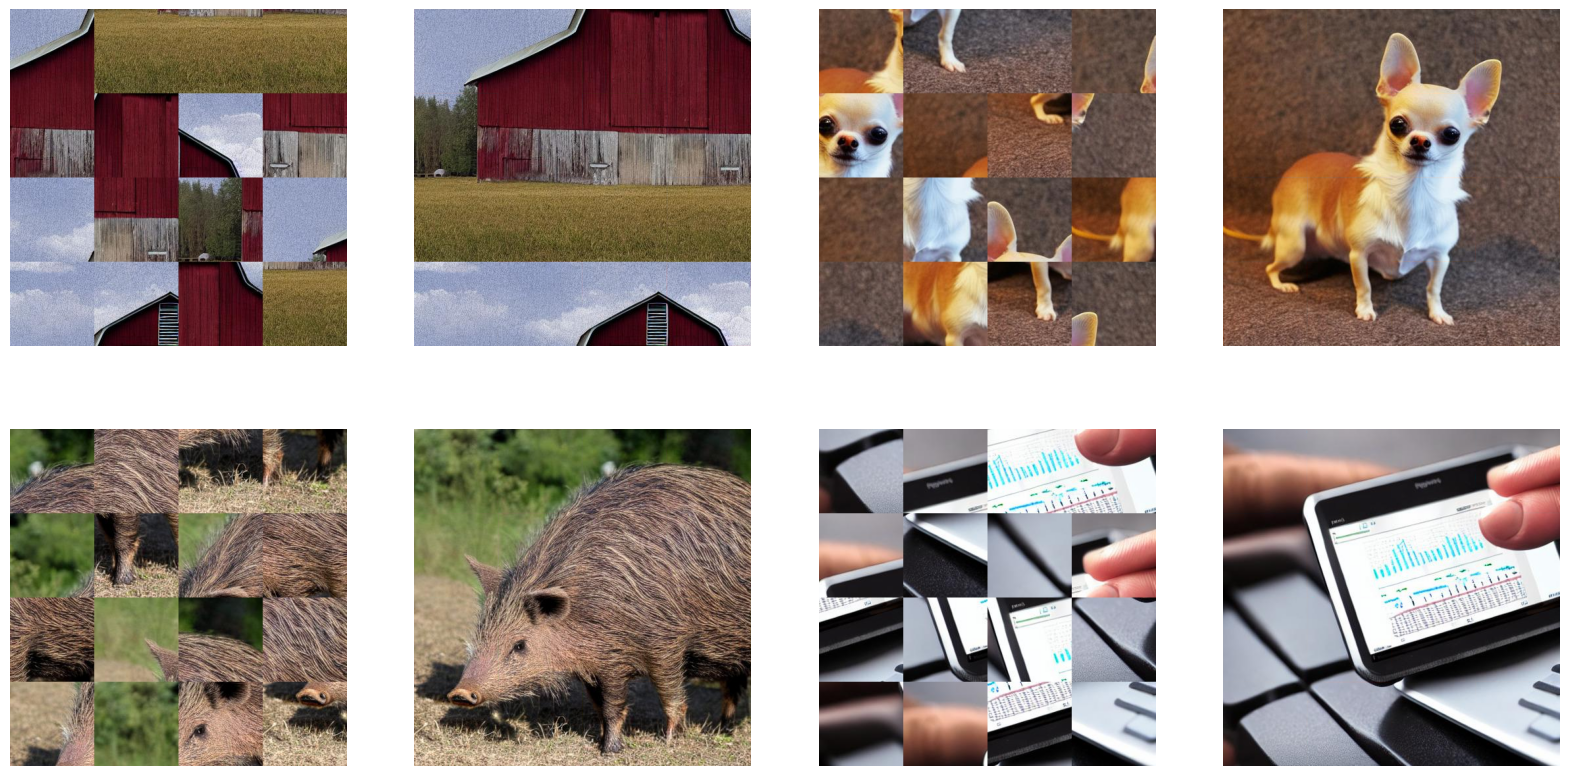

In [1]:
############
# Plotting #
############

import torch
import torchvision

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from puzzles_v2 import * 


cfg = {
    "batch_size":48,
    "img_size":512,
    "train_size":0.999,
    "num_layers":5,
    "channels":8,
    "pixel":2,
    
    "verbose":False,
    "label_prediction":True,
    "weight":0.9,
    "learning_rate":0.002,
    "weight_decay":0.0001,
    "num_epochs":100,
    "save_path":"/home/aiuser/taeuk/puzzle_saves",
    "path":"/home/aiuser/kyunghoney/data/Puzzle",
    "save_epoch":20
}
fix_random_seed(20240126)
_, _, test_loader = Loader(cfg)

dataset = test_loader.dataset
df = pd.read_csv("/home/aiuser/taeuk/puzzle_submit/M5_B48_L5_C8_W0.9_lr0.002_Px2_Ep100plus.csv")

num_images = 4
start_idx = 84

fig, axe = plt.subplots(num_images//2, 4, figsize=(20, 5*num_images//2))
for i in tqdm(range(num_images)):
    idx = start_idx + i
    image = DeNormalizing(dataset[idx][0]).squeeze()
    image = np.transpose(image, (1,2,0))
    label = df.iloc[idx, 1:] - 1
    solved = shuffle_image(image, label.argsort())[0]
    
    axe[(2*i)//4, (2*i)%4].imshow(image)
    axe[(2*i)//4, (2*i)%4].axis("off")
    axe[(2*i+1)//4, (2*i+1)%4].imshow(solved)
    axe[(2*i+1)//4, (2*i+1)%4].axis("off")
fig.show()

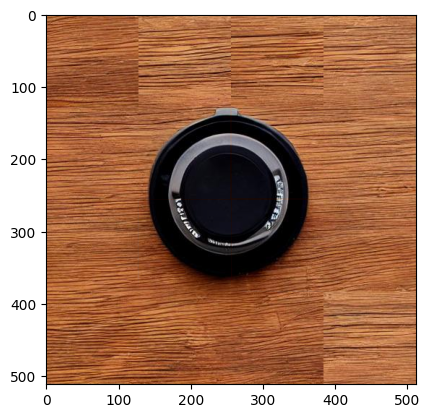

In [19]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
model_path = "/home/aiuser/taeuk/puzzle_saves/M5_B48_L5_C8_W0.9_lr0.002_Px2_Ep60.pt"

model = Model(cfg).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

img, imgs = dataset[54]
img = DeNormalizing(img)
imgs = DeNormalizing(imgs)
prob = model(imgs.to(device).unsqueeze(0)).softmax(dim=1)[:, 1, :, :].detach().cpu().numpy()
h = prob[0, :, :16]
v = prob[0, :, 16:]
answer = solving_v3(h, v, np.transpose(img.squeeze(), (1,2,0)))

plt.imshow(shuffle_image(np.transpose(img.squeeze(), (1,2,0)),
                         answer)[0])

In [59]:
i = 0 
tmp[i, :] - tmp[i+1, :]

array([-1, -5,  6, -9])